In [87]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

In [96]:
geo = SplineGeometry()
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "inlet"))
geo.AddCircle ( (0, 0), r=1, leftdomain=0, rightdomain=1, bc="cyl")
mesh = Mesh( geo.GenerateMesh(maxh=0.2))
mesh.Curve(3);
# viscosity
nu = 0.001

In [97]:
k = 3
V = VectorH1(mesh,order=k, dirichlet="top|bot|cyl|inlet|out")
Q = H1(mesh,order=k-1)
X = V*Q
#help(CoefficientFunction)

In [98]:
gfu = GridFunction(X)
velocity = gfu.components[0]
scene = Draw(velocity,mesh,"u")#,sd=3)
#scene2 = Draw(gfu.components[1],mesh,"p")#,sd=3)
#from ngsolve.internal import visoptions
#visoptions.scalfunction = "u:0"

# parabolic inflow at bc=1:
uinf = 0.001
uin = CoefficientFunction((uinf,0))
ball = CoefficientFunction((0,0))
init = uin + ball
#gfu.components[0].Set(ball, definedon=mesh.Boundaries("cyl"))
gfu.components[0].Set(init, definedon=mesh.Boundaries("inlet|top|bot|out"))

#gfu.componets[0] += gfu.components[0].Set(ball, definedon=mesh.Boundaries("cyl"))

# first component of gfu.components bedlongs to v ans has dim=2, [1] is tShe pressure broski
scene.Redraw()
#scene2.Redraw()


WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

In [99]:
(u,p), (v,q) = X.TnT()

a = BilinearForm(X)
stokes = (nu*InnerProduct(grad(u),grad(v))-div(u)*q-div(v)*p)*dx
a += stokes
a.Assemble()

f = LinearForm(X)
f.Assemble()

inv_stokes = a.mat.Inverse(X.FreeDofs())

res = f.vec.CreateVector()
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

scene.Redraw()
#scene2.Redraw()

## at this point we are basically done with navier stokes
* only need to calculate drag for this current properties
* change something on the ball, recalculate, go on
    * this isn't a real shape derivative, right? Because we don't really calculate, just simulate

In [100]:
# getting the drag in here
drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_x_vals = []
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res
drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
print(drag_x_vals)

[-0.0019903817002629477]


# try for shape thingies

In [94]:
#mesh.UnsetDeformation()
gfset = GridFunction(V)
Draw(gfset, mesh, "gfset")
SetVisualization(deformation=True)
gfset.components[0].Set((2), definedon=mesh.Boundaries("cyl"))
gfset.components[1].Set((0.5), definedon=mesh.Boundaries("cyl"))
mesh.SetDeformation(gfset)
Redraw()

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

In [31]:
help(mesh.SetDeformation)

Help on method SetDeformation in module ngsolve.comp:

SetDeformation(...) method of ngsolve.comp.Mesh instance
    SetDeformation(self: ngsolve.comp.Mesh, gf: ngcomp::GridFunction) -> None
    
    Deform the mesh with the given GridFunction



In [ ]:
# everything below here is "old/unused"

In [6]:
dt = 0.001
# matrix for implicit part of IMEX(1) scheme:
mstar = BilinearForm(X)
mstar += InnerProduct(u,v)*dx + dt*stokes
mstar.Assemble()
inv = mstar.mat.Inverse(X.FreeDofs())

conv = LinearForm(X)
conv += InnerProduct(grad(velocity)*velocity,v)*dx

In [7]:
t = 0
tend = 0
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt
    scene.Redraw()
    #scene2.Redraw()

t= 0.999000000000000876

In [42]:
# Supplementary 1

In [43]:
drag_x_test = GridFunction(X)
drag_x_test.components[0].Set(CoefficientFunction((-20.0,0)), definedon=mesh.Boundaries("cyl"))
drag_y_test = GridFunction(X)
drag_y_test.components[0].Set(CoefficientFunction((0,-20.0)), definedon=mesh.Boundaries("cyl"))

In [44]:
time_vals = []
drag_x_vals = []
drag_y_vals = []
# restoring initial data
res.data = f.vec - a.mat*gfu.vec
gfu.vec.data += inv_stokes * res

t = 0
tend = 0

In [45]:
# implicit Euler/explicit Euler splitting method:
tend += 1
while t < tend-0.5*dt:
    print ("\rt=", t, end="")

    conv.Assemble()
    res.data = a.mat * gfu.vec + conv.vec
    gfu.vec.data -= dt * inv * res

    t = t + dt
    scene.Redraw()
    #scene2.Redraw()

    time_vals.append( t )
    drag_x_vals.append(InnerProduct(res, drag_x_test.vec) )
    drag_y_vals.append(InnerProduct(res, drag_y_test.vec) )
    #print(drag)

t= 0.999000000000000876

In [10]:
import matplotlib.pyplot as plt
# Plot drag force over time
plt.plot(time_vals, drag_x_vals)
plt.xlabel('time'); plt.ylabel('drag'); plt.title('drag'); plt.grid(True)
plt.show()

NameError: name 'time_vals' is not defined

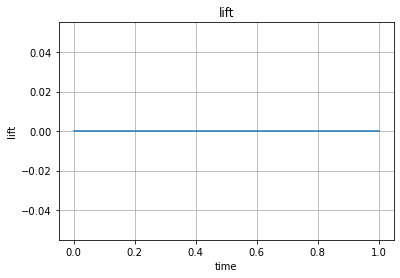

In [13]:
# Plot lift force over time
plt.plot(time_vals, drag_y_vals)
plt.xlabel('time'); plt.ylabel('lift'); plt.title('lift'); plt.grid(True)
plt.show()